Reference MLP paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

- The vectors will start all randomly placed in the 30dim space.
- As we train the model, it will learn the semantically similar words will get closer to each other.
- This helps us to generalize to unseen cases. If we know cat-dog are similar and likewise for (a,the) we can generalize to many unseen words.

#### Go over the neural architecture diagram
- Input: some context window of words
- The lookup table is shared for all timestamps
- Some number of hidden units (hyperparam) with tanh activation
- Softmax at the latest layer to predict the next word
- During training, maximize the probability of the next words
- Learned through backprop
- Ignore the residual connections!

In [177]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# read all words
words = open('../assets/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
special_char = '.'
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[special_char] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build the dataset
Explain what is Y and block size

In [11]:
block_size = 3 # context length

X,Y = [], []
for w in words[:5]:
    
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->',itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [16]:
output_dim = 2 #acceptable since we only have 27 chars in our model
vocab_size = 27
C = torch.randn((vocab_size,output_dim))


In [17]:
# How to access
C[5]

tensor([ 1.1187, -0.2084])

In [30]:
# One-hot
# remember casting to float
index = F.one_hot(torch.tensor(5),num_classes=vocab_size).float()

In [31]:
index

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
#identical 
index @ C 

tensor([ 1.1187, -0.2084])

Since it is the same thing, we will basically index and discard the one-hot approach.

In [35]:
# Pytorch indexing is highly flexible
# It can be array as well
C[torch.tensor([1,2,3,3,3])]

tensor([[ 2.9992, -1.2235],
        [ 0.4842,  0.3169],
        [ 0.7539, -1.5278],
        [ 0.7539, -1.5278],
        [ 0.7539, -1.5278]])

In [36]:
# We can even do this
C[X].shape

torch.Size([32, 3, 2])

In [37]:
X[13,2]

tensor(1)

In [38]:
C[X][13,2]

tensor([ 2.9992, -1.2235])

In [39]:
C[1]

tensor([ 2.9992, -1.2235])

In [40]:
# Embed everything simultaneously
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [41]:
# initialize the model
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [42]:
# How to concat the three inputs so we can multiply with W
# Maaaany ways to achieve this 

one way: https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat 

In [52]:
# Manual
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:],],dim=1).shape

torch.Size([32, 6])

In [53]:
# Generalized way
# Use unbind which removes a tensor dimension

https://pytorch.org/docs/stable/generated/torch.unbind.html#torch.unbind 

In [54]:
torch.unbind(torch.tensor([[1,2],[2,3]]))

(tensor([1, 2]), tensor([2, 3]))

In [56]:
torch.unbind(emb,dim=1)[0].shape

torch.Size([32, 2])

In [57]:
len(torch.unbind(emb,dim=1))

3

In [58]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [59]:
emb_ = torch.unbind(emb,dim=1)

In [60]:
len(emb_),emb_[0].shape

(3, torch.Size([32, 2]))

In [61]:
con_emb_ = torch.cat(emb_,dim=1)

In [62]:
con_emb_.shape

torch.Size([32, 6])

In [63]:
# There is actually much more efficient way of doint this
# Without swapping memories
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [64]:
a.shape

torch.Size([18])

In [65]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

Extremely efficient because the underlying storage doesn't change!! 
We are only manipulating how this sequence is interpreted so we don't make any memory operations!! see `a.storage()`.

Optional reading on this: http://blog.ezyang.com/2019/05/pytorch-internals/

In [68]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [69]:
emb.shape

torch.Size([32, 3, 2])

In [71]:
emb.view(32,6) == con_emb_

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [73]:
a = torch.arange(24)
a.view(3,4,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11],
         [12, 13],
         [14, 15]],

        [[16, 17],
         [18, 19],
         [20, 21],
         [22, 23]]])

In [74]:
a.view(6,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]])

In [75]:
# alternatively you can also use -1 for the first dim
h = emb.view(emb.shape[0],6) @ W1 +b1

In [77]:
h = torch.tanh(h)

In [78]:
h.shape

torch.Size([32, 100])

In [79]:
# reminder about broadcasting of b1
# 32, 100
# (1) 100
# to be safe you can also declare b1 as torch.randn((1,100))

In [80]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [81]:
logits = h@ W2 +b2

In [82]:
logits.shape

torch.Size([32, 27])

In [83]:
# exponentiate to get the fake counts
counts = logits.exp()

In [87]:
# another broadcasting here
prob = counts / counts.sum(1,keepdims=True)

In [89]:
prob.shape

torch.Size([32, 27])

In [92]:
#get probs for correct continuations
# how to index it
prob[torch.arange(32),Y]

tensor([4.4364e-08, 4.6486e-07, 6.0307e-09, 9.3952e-12, 4.2877e-03, 4.5098e-08,
        2.2291e-07, 2.3784e-05, 2.3665e-10, 2.0776e-06, 8.2781e-07, 4.2196e-02,
        1.8992e-05, 2.2370e-05, 1.5717e-03, 9.9949e-06, 3.0955e-07, 9.1311e-10,
        2.2856e-03, 2.0201e-05, 2.7432e-08, 5.1033e-16, 6.4684e-11, 7.3463e-09,
        1.0098e-13, 3.5404e-10, 4.9650e-08, 1.1677e-10, 1.3497e-03, 2.6709e-07,
        1.0573e-05, 6.5300e-07])

In [93]:
#MLE!! negative log likelihood
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(15.7016)

In [94]:
# -------- putting it all together ----------------
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [100]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [101]:
sum(p.nelement() for p in parameters)

3481

In [105]:
# forward pass
h = torch.tanh(C[X].view(-1,6)@ W1+b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1,keepdims=True)
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(16.8879)

further improve. Lets not reinvent the wheel. Since we are doing classification, we can use the pre-built cross_entropy from torch. 

Reference: https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html

In [106]:
# Get the same thing!
loss2 = F.cross_entropy(logits,Y)
loss2

tensor(16.8879)

In [107]:
# forward pass
h = torch.tanh(C[X].view(-1,6)@ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)

Why actually always use F.cross_entropy?

1. Efficiency: 

- PyTorch uses fused kernels for fast calculation
- Since the expression is pre-built, pytorch knows exactly what to do on the backward step.
- On the contrary, if we hand write the long expression, pytorch will have to make 3-4 separate backward steps.
- This is similar to the case the we built the `_backward()` operation for `tanh()` in lecture 1. In that case the backward was single operation. we did not calculate the backward for all individual steps like `2*x` or `math.exp(.)` 

2. Numerically well behaved!!


In [ ]:
# Explain 2

In [108]:
# forward pass
h = torch.tanh(C[X].view(-1,6)@ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)

In [111]:
logits = torch.tensor([-2,-3,-0,1000])
counts = logits.exp()
probs = counts/counts.sum()
probs

tensor([0., 0., 0., nan])

In [113]:
# because e^1000 is overflowing
counts

tensor([0.1353, 0.0498, 1.0000,    inf])

In [115]:
# subtract the max  trick for preventing overflow
logits = torch.tensor([-5,-3,0,1000]) - 1000
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., 1.])

In [116]:
# Continue training from here

In [117]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [118]:
sum(p.nelement() for p in parameters)

3481

In [119]:
for p in parameters:
    p.requires_grad= True

In [121]:
epoch = 100
for _ in range(epoch):
    # forward pass
    emb = C[X] # shape (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.2849053740501404


Loss is super low because we are overfitting to 32 samples!! We have 3481 params to fit 32 samples

Go over why it is not zero? Because there are some ambiguous cases such as "..." -> "e" or "o".

We could only overfit to cases where there is one single answer!!

In [124]:
logits.max(1)

torch.return_types.max(
values=tensor([ 8.6770, 13.5366, 12.1110, 12.9143, 16.6655,  8.6770, 14.2060, 13.1895,
        11.1739, 13.4428, 15.1191, 20.6045,  8.6770, 14.8853, 10.4620, 15.5376,
         8.6770, 12.6185, 14.6243, 14.3542, 13.2918, 15.6934, 13.5731, 16.5784,
        18.7177,  8.6770, 14.3525, 14.5067, 18.2000, 12.0925, 17.6595, 18.2331],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [125]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

### Let's fit the whole dataset!

In [128]:
block_size = 3 # context length

X,Y = [], []
for w in words:
    
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [129]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [134]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [135]:
for p in parameters:
    p.requires_grad= True

In [136]:
epoch = 10
for _ in range(epoch):
    # forward pass
    emb = C[X] # 
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad


16.261137008666992
14.354217529296875
13.208730697631836
12.27278995513916
11.476091384887695
10.803886413574219
10.234297752380371
9.751381874084473
9.338600158691406
8.974411010742188


#### Each pass is taking super long. Let's fix that by using mini-batch GD

In [138]:
torch.randint(0,X.shape[0],(32,))

tensor([ 16484, 106304, 205810,  72380,  25389, 216832,  46905,   2905, 142763,
        119890,  12897,  95169, 136946, 128679,  97235,  52561,  97842, 217865,
           298,  62415, 106205, 122780, 160425, 221446, 155054,  43179,  32255,
        225916, 201485,  64244, 116188, 127472])

In [139]:
ixs = torch.randint(0,X.shape[0],(32,))

In [143]:
ixs.shape

torch.Size([32])

In [145]:
mini_batch = C[X[ixs,:]]

In [146]:
mini_batch.shape

torch.Size([32, 3, 2])

In [149]:
Y[ixs].shape

torch.Size([32])

In [151]:
# Mini-batch GD
epoch = 1000
batch_size = 32
for _ in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,X.shape[0],(batch_size,))
    mini_batch = X[ixs,:]
    mini_batch_y = Y[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.1 * p.grad


5.786375522613525
6.403128147125244
6.80225133895874
6.06060791015625
7.589287757873535
4.2227349281311035
5.345100402832031
7.790638446807861
5.491888523101807
4.7262959480285645
3.7177765369415283
8.192079544067383
4.89778995513916
5.6328606605529785
4.711860179901123
4.115666389465332
5.319376468658447
4.4306559562683105
5.341001510620117
4.376426696777344
5.699900150299072
4.294360160827637
3.7718677520751953
4.615455627441406
3.257601499557495
5.104333400726318
3.4387810230255127
3.8484137058258057
4.235711574554443
3.219099521636963
3.7625226974487305
4.1864542961120605
2.5818674564361572
4.479804992675781
5.376302719116211
3.359419345855713
3.3898813724517822
3.5898547172546387
3.628901481628418
3.0259146690368652
4.173199653625488
3.6626369953155518
3.2856738567352295
3.618631601333618
3.9194424152374268
4.436309814453125
5.620206356048584
4.229266166687012
3.803269624710083
3.826616048812866
3.357684373855591
4.2338409423828125
3.5388476848602295
3.7107174396514893
3.751038789

2.727013349533081
2.7449629306793213
2.488781213760376
2.0670130252838135
3.107228994369507
2.637169122695923
3.034088134765625
2.410733938217163
3.1715381145477295
2.4798922538757324
2.9612817764282227
2.7822718620300293
2.7331082820892334
3.028606414794922
2.875253677368164
2.5379347801208496
2.9528496265411377
2.7735965251922607
2.862872838973999
2.5806479454040527
2.836214303970337
3.037170648574829
2.6590816974639893
2.1955666542053223
2.5898704528808594
2.8545305728912354
2.5227534770965576
2.787403106689453
2.5531256198883057
2.6683573722839355
2.5199596881866455
3.064303398132324
2.380654811859131
2.4404070377349854
2.6373414993286133
2.5702335834503174
2.531750202178955
2.673781394958496
3.138225555419922
3.0648984909057617
3.1545581817626953
2.9024369716644287
2.578991174697876
2.583022356033325
2.7654123306274414
2.6888253688812256
2.6807806491851807
2.5287649631500244
2.7163991928100586
2.554313898086548
2.7153613567352295
2.5656211376190186
2.4589157104492188
2.76156902313

Since we are using mini batches, each individual gradient is more noisy but overall it sums up nicely. It is more efficient to make many somewhat correct steps, instead of few correct steps.

#### How do you determine your learning rate is correct (neither too small nor too big)??

If learning rate is very low we wont see any progress. if too big it will blow up.


- Try many extreme values like 0.00001 and 10 to come up with a rough estimate of the range.
- Then run hyperparameter search

In [168]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [169]:
for p in parameters:
    p.requires_grad= True

In [170]:
# we should sample from the log scale
lre = torch.linspace(-3,0,1000,requires_grad=False)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [171]:
# Mini-batch GD
epoch = 1000
batch_size = 32
lri = []
lossi = []
for i in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,X.shape[0],(batch_size,))
    mini_batch = X[ixs,:]
    mini_batch_y = Y[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lr)
    lossi.append(loss.item())

13.365704536437988
14.148274421691895
16.171045303344727
14.3372163772583
14.996829986572266
13.104650497436523
15.710430145263672
13.263768196105957
12.976149559020996
14.394404411315918
16.763919830322266
16.49031639099121
14.891071319580078
13.3933744430542
13.58803653717041
14.168462753295898
15.527363777160645
13.533979415893555
12.244095802307129
16.690366744995117
15.786914825439453
11.864158630371094
15.865274429321289
13.909329414367676
13.31160831451416
14.070466041564941
14.185494422912598
14.49293041229248
14.985494613647461
14.951014518737793
14.202820777893066
12.637670516967773
15.378809928894043
14.121330261230469
16.167064666748047
15.029653549194336
13.774625778198242
11.395874977111816
14.33232307434082
14.102524757385254
12.610724449157715
15.114350318908691
14.730607986450195
13.372964859008789
13.627256393432617
14.726616859436035
15.204427719116211
15.946502685546875
12.452427864074707
11.06043815612793
13.442298889160156
13.75441837310791
12.123719215393066
10.4

3.978483200073242
4.691576957702637
3.528175115585327
3.7718117237091064
5.409267902374268
5.049508094787598
4.50767183303833
6.651455402374268
4.378150463104248
4.089488506317139
4.364913463592529
3.217946767807007
3.469348192214966
5.95911979675293
7.330340385437012
11.271224975585938
8.823877334594727
4.792705535888672
4.5939459800720215
5.0544023513793945
4.747861385345459
6.525347709655762
4.1698079109191895
3.517338275909424
5.082663536071777
8.241408348083496
4.749773979187012
7.044714450836182
8.156347274780273
4.687533378601074
5.519313812255859
5.759998798370361
5.839644908905029
5.844503879547119
4.3915934562683105
5.243415832519531
7.041904926300049
6.609964847564697
5.939275741577148
5.734142303466797
2.813887596130371
4.226243495941162
4.983874320983887
6.022886753082275
4.7775421142578125
5.89966344833374
6.191433906555176
5.729623317718506
5.223484992980957
6.299342632293701
4.535141944885254
4.721187591552734
6.282458305358887
5.421631813049316
5.6520771980285645
7.831

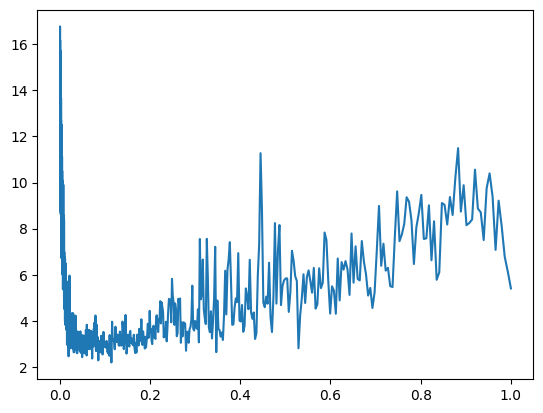

In [172]:
plt.plot(lri,lossi)

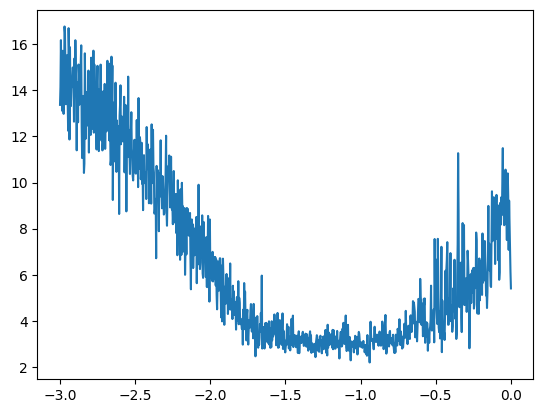

In [179]:
# 10**-1 was actually good
plt.plot(np.log10(lri),lossi)

**Observations**

- Beginning was too low
- Then around somewhere it started getting too big and got unstable
- Pick the region where it was consistent
- Good lr is on the consistent region

## Lets crank up the iterations and do it again

In [191]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [192]:
for p in parameters:
    p.requires_grad= True

In [211]:
# Mini-batch GD
epoch = 10000
batch_size = 32
for _ in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,X.shape[0],(batch_size,))
    mini_batch = X[ixs,:]
    mini_batch_y = Y[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01
    for p in parameters:
        p.data += - l_r* p.grad


In [212]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.3588647842407227

In [ ]:
# Then lets decay the learning rate after 30k iterations
# We already surpassed the bigram error which was 2.45

### Overfitting 

- We already surpassed the bigram error which was 2.45
- But this doesnt mean that our model is actually better
- Since we have 3481 parameters, it is easier to overfit
- Better approach is to have a train/dev/test split
- Evaluate hyperparam changes on the dev set 
- Compare results on test set (compare with other model)
- Do the last comparison sparingly because we would overfit to test set

## Data Splitting


In [227]:
# build dataset

def build_dataset(words):
    block_size = 3 # context length

    X,Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

#random shuffling
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])


torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [219]:
torch.cat([Xtr,Xdev,Xte],dim=0).shape == X.shape

True

In [222]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [223]:
for p in parameters:
    p.requires_grad= True

In [230]:
# Mini-batch GD
# Only train on Xtr
epoch = 10000
batch_size = 32
for _ in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,))
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,6) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update
    l_r = 0.01
    for p in parameters:
        p.data += - l_r* p.grad
print(loss.item())

2.654650926589966


In [231]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.3484723567962646

In [232]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.346670389175415

### Underfitting

- Our training loss is big 2.34
- But our dev and train losses are quite similar (low variance)
- This means we are definitely underfitting (high bias)
- We can solve this by scaling up the size of the network

In [270]:
hidden_size = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad= True

In [271]:
sum(p.nelement() for p in parameters)

11897

In [274]:
stepi = []
lossi = []

In [284]:
# Mini-batch GD
# Only train on Xtr
epoch = 50000
batch_size = 32
for i in range(epoch):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,))
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    h = torch.tanh(emb.view(-1,30) @ W1+b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update
    l_r = 0.01
    for p in parameters:
        p.data += - l_r* p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

1.9438235759735107


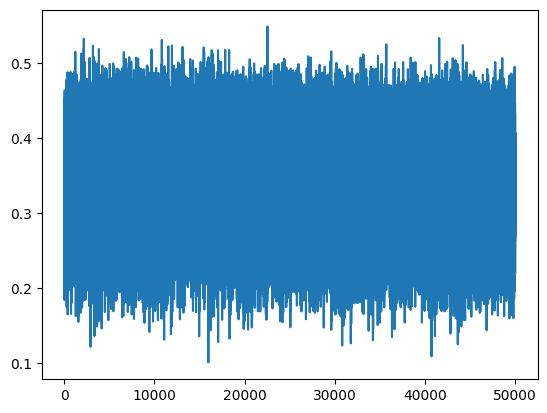

In [285]:
# noisy due to mini-batch
# increasing batch size would help us remove the mini-batch noise
plt.plot(stepi,lossi)

In [286]:
# dev eval
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.136791706085205

In [287]:
# train eval
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.0916059017181396

- Another point is that maybe embedding dim is too low
- Might consider increasing that as well

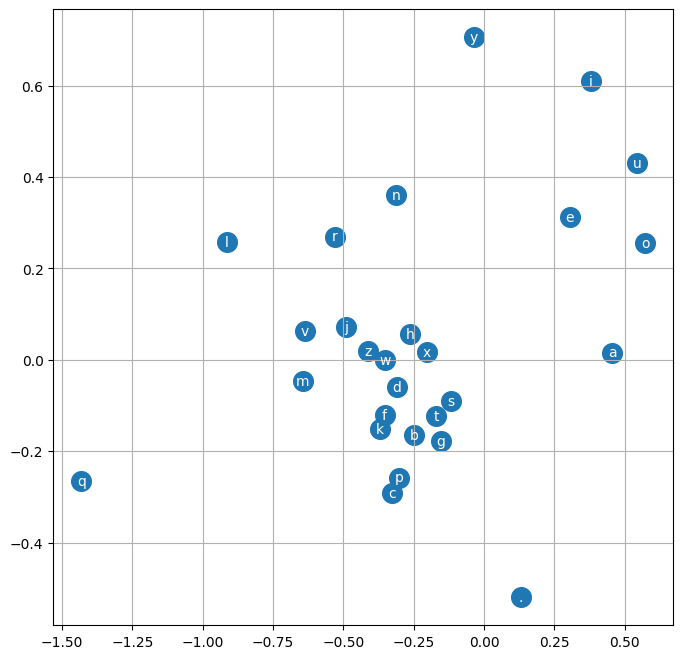

In [269]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

**Observations**
- See that vowels nicely clustered together!!!
- q is unique
- . is separate

- Last thing we try is we moved embedding dim from 2 to 10. 
- Learning rate decay is also done manually several times 
- See if we improve the final performance

### Overfit 
- Now our model is larger 
- We might start seeing train loss is getting separated from dev loss
- This is a sign that finally we have enough capacity to overfit.


**Things to improve perf.**

- block size different
- embedding size different
- How long we run
- hidden size
- batch size
- learning rate.


### Challenge

Try to beat the 2.13 dev score  achieved about.


### Finally

Sample from the model

In [291]:
# Sample from the trained model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
nihah.
larethruthng.
leg.
adelyn.
elin.
shy.
jenne.
elissopharleilyn.
houra.
noshuberglairiel.
kin.
renlynn.
nopulfy.
brence.
ryylene.
elsyn.
ajahshournihia.
